# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [2]:
def my_make_data(w, b, n):
    """伪造X，y"""
    X = torch.normal(0, 1, (n, len(w)))
    y = torch.mv(X, w) + b + torch.normal(0, 0.01, (n,))
    return X, y.reshape((-1, 1))
w = torch.tensor([2, 3.0])
b = 4.3
n = 3
X = my_make_data(w, b, n)
X

(tensor([[ 0.6468,  0.5418],
         [-0.3164,  0.1121],
         [ 0.1135, -0.0568]]),
 tensor([[7.2178],
         [4.0170],
         [4.3686]]))

In [3]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features, labels

(tensor([[ 0.3623,  0.4261],
         [ 1.1743, -0.0747],
         [-0.4471, -0.6603],
         ...,
         [-1.0798,  0.6313],
         [ 0.2061,  0.5234],
         [-0.9289, -0.2856]]),
 tensor([[ 3.4775e+00],
         [ 6.8192e+00],
         [ 5.5399e+00],
         [-9.7519e-01],
         [ 8.2863e-01],
         [ 1.9602e+00],
         [ 1.3149e+01],
         [ 5.4296e+00],
         [ 8.4106e+00],
         [ 1.2359e+01],
         [ 2.4731e+00],
         [ 2.7458e+00],
         [ 4.1169e+00],
         [ 1.6004e+00],
         [ 6.0106e+00],
         [ 8.8141e-01],
         [ 2.3158e+00],
         [-3.3505e+00],
         [ 4.2156e+00],
         [ 3.1599e+00],
         [ 2.5660e+00],
         [-3.1338e+00],
         [ 4.8197e-01],
         [ 9.0086e+00],
         [-1.0249e+00],
         [ 3.5010e+00],
         [ 6.1350e+00],
         [ 1.1173e+01],
         [ 1.6489e+00],
         [ 8.7090e+00],
         [ 1.2349e+01],
         [ 1.6581e+00],
         [ 4.0513e+00],
         [ 7.4532e

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.3623, 0.4261]) 
label: tensor([3.4775])


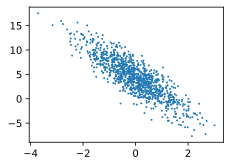

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1405,  0.3551],
        [ 0.1582,  0.8731],
        [ 0.3265,  0.7846],
        [-1.2171, -0.6324],
        [-0.7973, -0.1564],
        [-0.2327, -0.4698],
        [-1.0379,  0.1378],
        [-0.6238,  0.4276],
        [-0.2218, -0.0611],
        [-0.3695,  0.0695]]) 
 tensor([[5.2495],
        [1.5399],
        [2.1720],
        [3.9096],
        [3.1374],
        [5.3290],
        [1.6437],
        [1.5048],
        [3.9539],
        [3.2255]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [7]:
# 参数初始化，添加梯度参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [8]:
help(torch.mv)

Help on built-in function mv in module torch:

mv(...)
    mv(input, vec, *, out=None) -> Tensor
    
    Performs a matrix-vector product of the matrix :attr:`input` and the vector
    :attr:`vec`.
    
    If :attr:`input` is a :math:`(n \times m)` tensor, :attr:`vec` is a 1-D tensor of
    size :math:`m`, :attr:`out` will be 1-D of size :math:`n`.
    
    .. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
    
    Args:
        input (Tensor): matrix to be multiplied
        vec (Tensor): vector to be multiplied
    
    Keyword args:
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> mat = torch.randn(2, 3)
        >>> vec = torch.randn(3)
        >>> torch.mv(mat, vec)
        tensor([ 1.0404, -0.6361])



In [9]:
help(torch.matmul)

Help on built-in function matmul in module torch:

matmul(...)
    matmul(input, other, *, out=None) -> Tensor
    
    Matrix product of two tensors.
    
    The behavior depends on the dimensionality of the tensors as follows:
    
    - If both tensors are 1-dimensional, the dot product (scalar) is returned.
    - If both arguments are 2-dimensional, the matrix-matrix product is returned.
    - If the first argument is 1-dimensional and the second argument is 2-dimensional,
      a 1 is prepended to its dimension for the purpose of the matrix multiply.
      After the matrix multiply, the prepended dimension is removed.
    - If the first argument is 2-dimensional and the second argument is 1-dimensional,
      the matrix-vector product is returned.
    - If both arguments are at least 1-dimensional and at least one argument is
      N-dimensional (where N > 2), then a batched matrix multiply is returned.  If the first
      argument is 1-dimensional, a 1 is prepended to its dimens

In [10]:
# a = torch.ones((2, 3), requires_grad=True)
# b = torch.ones((3))
# print(torch.mv(a,b ))
# print(torch.matmul(a, b))
# y = torch.mv(a,b)
# y.sum().backward()
# a.grad

In [11]:
def linreg(X, w, b):  
    """线性回归模型"""
#     return torch.matmul(X, w) + b
#     print(X.shape, w.shape)
    w = torch.squeeze(w)
#     print(X.shape, w.shape)

    return torch.mv(X, w) + b
#     return torch.matmul(X, w) + b

定义损失函数

In [12]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # TODO 为啥要/2  numel

定义优化算法

In [13]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 参数消费梯度
            param.grad.zero_() # 参数梯度清零

训练过程

In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031567
epoch 2, loss 0.000108
epoch 3, loss 0.000047


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [15]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([6.1357e-04, 3.0279e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
